In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.1 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
n_epochs = 100   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 0    # Size of the train dataset
n_test = 0     # Size of the test dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
SAVE_PATH = "/content/drive/MyDrive/ctscan"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
train_path="/content/drive/MyDrive/ctscan/Train"
test_path="/content/drive/MyDrive/ctscan/Test"
train_img=[]
train_lbl=[]
n_train=0
n_test=0

In [9]:
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        n_train+=1
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        train_img.append(img_arr)
        train_lbl.append(0 if folder=='COVID' else (1 if folder=='non-COVID' else 2))
test_img=[]
test_lbl=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        n_test+=1
        image_path=sub_path+"/"+img
        #print('tp1',image_path)
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        test_img.append(img_arr)
        test_lbl.append(0 if folder=='COVID' else 1 if folder=='non-COVID' else 2)
train_images = np.array(train_img)
train_labels = np.array(train_lbl)
test_images = np.array(test_img)
test_labels = np.array(test_lbl)

In [10]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

In [11]:
# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
if 1==1:   #1 for pennylane simulator, any number for IBM QPU
    dev = qml.device("lightning.qubit", wires=4)
else:
    from qiskit_ibm_runtime import QiskitRuntimeService
    service = QiskitRuntimeService('ibm_quantum','8791a7c6af1662114ae85a2ccd7c6f7c82a9ecd9b71e7d95003b7743b6d5a1a18975ffbfc90a8cbb0429601eba88e1c4043bd0f6e96809c0f6875b0b7fe7852c')
    backend = service.least_busy(operational=True, simulator=False)
    print("Running on IBM QPU ",backend)
    dev = qml.device("qiskit.remote", wires=4, backend=backend)


In [14]:
# Set up the device with 8 qubits
dev = qml.device("default.qubit", wires=10)

H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])

In [23]:
# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)

    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

In [ ]:
# Set up the device with 8 qubits
dev = qml.device("default.qubit", wires=10)

H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)

    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # First Convolution

    qml.CRY(phi=phis[0], wires=[7, 6])

    qml.CRY(phi=phis[1], wires=[6, 5])

    qml.CRY(phi=phis[2], wires=[5, 4])

    qml.CRY(phi=phis[3], wires=[4, 7])

    qml.CRY(phi=phis[4], wires=[3, 2])

    qml.CRY(phi=phis[5], wires=[2, 1])

    qml.CRY(phi=phis[6], wires=[1, 0])

    qml.CRY(phi=phis[7], wires=[0, 3])

    qml.Barrier()


    # First Pooling

    qml.CRZ(phi=phis[8], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[9], wires=[7, 6])

    qml.CRZ(phi=phis[8], wires=[3, 2])
    qml.X(wires=3)
    qml.CRX(phi=phis[9], wires=[3, 2])

    qml.Barrier()

    # Activations 1
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[10], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[11], wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(phi=phis[12], wires=2)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[13], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[14], wires=5)
    qml.Hadamard(wires=6)
    qml.RZ(phi=phis[15], wires=6)

    qml.Barrier()

    # Second Convolution

    qml.CRY(phi=phis[16], wires=[6, 5])

    qml.CRY(phi=phis[17], wires=[5, 4])

    qml.CRY(phi=phis[18], wires=[4, 6])

    qml.CRY(phi=phis[19], wires=[2, 1])

    qml.CRY(phi=phis[20], wires=[1, 0])

    qml.CRY(phi=phis[21], wires=[0, 2])

    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[22], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[23], wires=[6, 5])

    qml.CRZ(phi=phis[22], wires=[2, 1])
    qml.X(wires=2)
    qml.CRX(phi=phis[23], wires=[2, 1])

    qml.Barrier()

    # Activations 2
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[24], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[25], wires=1)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[26], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[27], wires=5)

    qml.Barrier()

    # Third Convolution

    qml.CRY(phi=phis[28], wires=[5, 4])

    qml.CRY(phi=phis[29], wires=[4, 5])

    qml.CRY(phi=phis[30], wires=[1, 0])

    qml.CRY(phi=phis[31], wires=[0, 1])

    qml.Barrier()

    # Third Pooling

    qml.CRZ(phi=phis[32], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[33], wires=[5, 4])

    qml.CRZ(phi=phis[32], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[33], wires=[1, 0])

    # Ancilla qubits
    qml.CNOT(wires=[0, 8])
    qml.CNOT(wires=[4, 9])

    # Return the final state vector
    return qml.probs(wires=[8, 9])

results = []

for i in range(100):
    # Execute the circuit and retrieve the state vector
    phis = np.random.uniform(-1, 1, size=34)
    state_vector = quantum_circuit(train_images[i], phis)

    # Convert the state vector into probabilities by taking the absolute square of each amplitude
    probabilities = np.abs(state_vector)**2

    results.append(probabilities)

    # Print the resulting probabilities
    #print("Probabilities:", probabilities.numpy())

    # Reshape the probabilities array into a 16x16 array for the heatmap
    '''probabilities_reshaped = probabilities.reshape(2, 2)'''

    # Create a heatmap of the probabilities using seaborn
    '''plt.figure(figsize=(8, 6))
    sns.heatmap(probabilities_reshaped, annot=False, cmap="viridis")

    # Add labels and title
    plt.title("Heatmap of Probabilities for 8-Qubit Quantum Circuit")
    plt.xlabel("State Index (0-15)")
    plt.ylabel("State Index (0-15)")'''

    # Show the plot
    #plt.show()

highest = {0: 0, 1: 0, 2: 0, 3: 0}

for i in results:
    ind = 0
    m = i[0]

    if i[1] > m:
        ind = 1
        m = i[1]
    if i[2] > m:
        ind = 2
        m = i[2]
    if i[3] > m:
        ind = 3
        m = i[3]

    highest[ind] += 1

highest

In [44]:

for i in results:
    print(i**(1/2))

In [52]:
drawer = qml.draw_mpl(quantum_circuit)(train_images[0], phis)
print(drawer)

ValueError: State must be a one-dimensional tensor, or two-dimensional with batching; got shape (224, 224, 3, 1).

In [54]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        self.phis = torch.nn.Parameter(torch.empty(34))  # Create an uninitialized tensor of size 17
        torch.nn.init.uniform_(self.phis, a=-0.314, b=0.314)  # Initialize phis with values between -0.01 and 0.01

    def forward(self, x):
        # Call the quantum circuit and return the log-probabilities
        constrained_phis = self.phis * np.pi  # Optional: Mapping the parameters to [-pi, pi] without tanh
        return torch.log(quantum_circuit(x, constrained_phis))


NameError: name 'torch' is not defined

In [ ]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

In [ ]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    n1=14
    n2=14
    n3=4
    out = np.zeros((n1, n2, n3))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, n1, 2):
        for k in range(0, n2, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)



Quantum pre-processing of train images:


/tmp/ipython-input-9-2514195050.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j // 2, k // 2, c] = q_results[c]



Quantum pre-processing of test images:


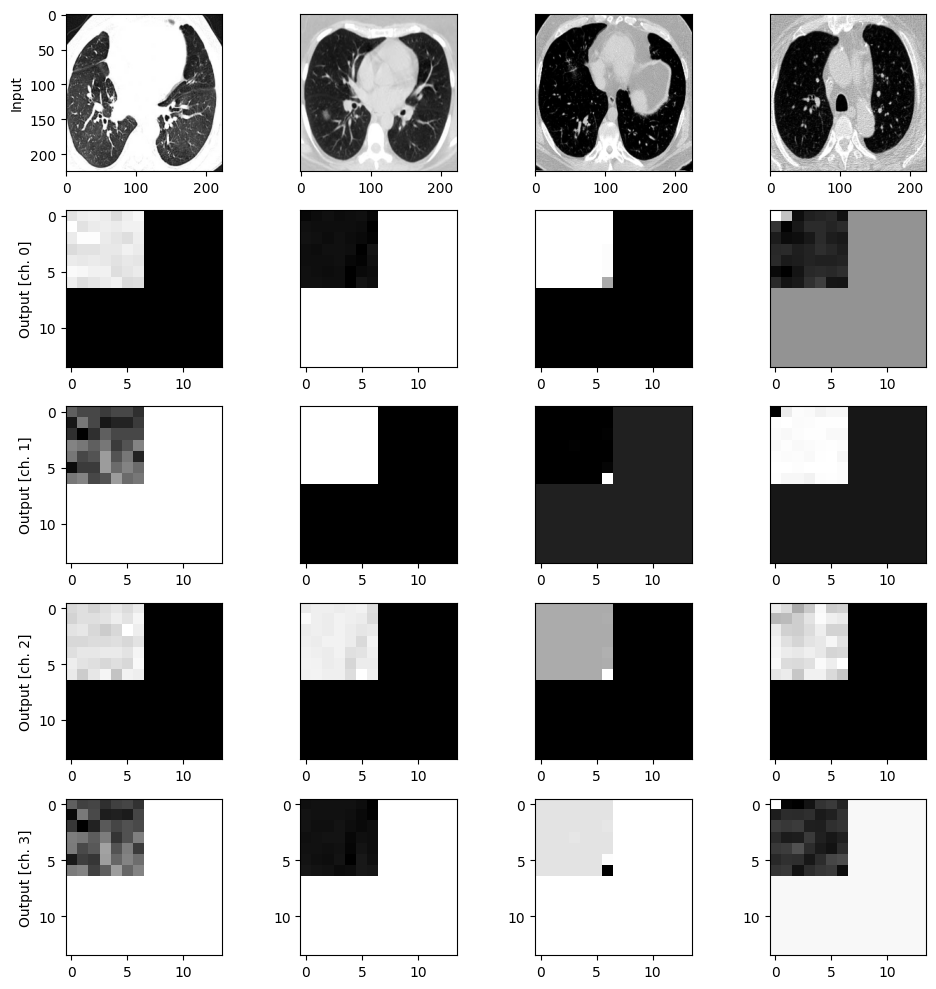

In [ ]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
#plt.show()

In [ ]:
def MyQModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    num_filters = 8 #8
    filter_size = 4 #3
    pool_size = 3

    model = Sequential([
        Conv2D(num_filters, filter_size, input_shape=(14,14,4)),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dense(4,activation='softmax'),
    ])

    model.compile(
        'adamax',
        loss='SparseCategoricalCrossentropy',
        metrics=['accuracy'],
    )
    #print(model.summary())
    return model


In [ ]:
def MyCModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    num_filters = 8 #8
    filter_size = 4 #3
    pool_size = 3

    model = Sequential([
        Conv2D(num_filters, filter_size, input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dense(3,activation='softmax'),
    ])

    model.compile(
        'adamax',
        loss='SparseCategoricalCrossentropy',
        metrics=['accuracy'],
    )
    #print(model.summary())
    return model



In [ ]:
q_model = MyQModel()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print(q_train_images.shape)

(2521, 14, 14, 4)


In [ ]:
print(q_train_images.shape)
print(q_train_images[0])

(2521, 14, 14, 4)
[[[ 0.65992453 -0.16129068  0.37109688 -0.11227992]
  [ 0.69613395 -0.18555659  0.3840279  -0.13241507]
  [ 0.70492555 -0.18555659  0.36454639 -0.13080358]
  [ 0.68723669 -0.19764822  0.3840279  -0.1460638 ]
  [ 0.64121331 -0.18555659  0.39672577 -0.13400645]
  [ 0.69613395 -0.18555659  0.37759104 -0.13080358]
  [ 0.72218645 -0.20970985  0.40298486 -0.1441203 ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.74725253 -0.23373579  0.36454639 -0.17273284]
  [ 0.65992453 -0.13692685  0.3840279  -0.09410115]
  [ 0.68723669 -0.18555659  0.3840279  -0.1275213 ]
  [ 0.69613395 -0.23373579  0.39040646 -0.15852782]
  [ 0.68723669 -0.22173965  0.40918279 -0.15

In [ ]:
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/100
631/631 - 6s - 9ms/step - accuracy: 0.5728 - loss: 0.7433 - val_accuracy: 0.5782 - val_loss: 0.6735
Epoch 2/100
631/631 - 4s - 6ms/step - accuracy: 0.6093 - loss: 0.6604 - val_accuracy: 0.6143 - val_loss: 0.6480
Epoch 3/100
631/631 - 3s - 5ms/step - accuracy: 0.6248 - loss: 0.6439 - val_accuracy: 0.6266 - val_loss: 0.6326
Epoch 4/100
631/631 - 6s - 9ms/step - accuracy: 0.6343 - loss: 0.6330 - val_accuracy: 0.6218 - val_loss: 0.6215
Epoch 5/100
631/631 - 4s - 7ms/step - accuracy: 0.6406 - loss: 0.6254 - val_accuracy: 0.6239 - val_loss: 0.6138
Epoch 6/100
631/631 - 5s - 8ms/step - accuracy: 0.6402 - loss: 0.6203 - val_accuracy: 0.6273 - val_loss: 0.6079
Epoch 7/100
631/631 - 5s - 8ms/step - accuracy: 0.6450 - loss: 0.6167 - val_accuracy: 0.6280 - val_loss: 0.6036
Epoch 8/100
631/631 - 3s - 5ms/step - accuracy: 0.6450 - loss: 0.6141 - val_accuracy: 0.6259 - val_loss: 0.6005
Epoch 9/100
631/631 - 5s - 8ms/step - accuracy: 0.6454 - loss: 0.6122 - val_accuracy: 0.6294 - val_loss:

In [ ]:
c_model = MyCModel()

In [ ]:
print(train_images.shape)
print(train_images[0])


(2521, 224, 224, 3, 1)
[[[[0.27058824]
   [0.27058824]
   [0.27058824]]

  [[0.2627451 ]
   [0.2627451 ]
   [0.2627451 ]]

  [[0.25490196]
   [0.25490196]
   [0.25490196]]

  ...

  [[0.25882353]
   [0.25882353]
   [0.25882353]]

  [[0.27843137]
   [0.27843137]
   [0.27843137]]

  [[0.23921569]
   [0.23921569]
   [0.23921569]]]


 [[[0.24705882]
   [0.24705882]
   [0.24705882]]

  [[0.25490196]
   [0.25490196]
   [0.25490196]]

  [[0.25490196]
   [0.25490196]
   [0.25490196]]

  ...

  [[0.2627451 ]
   [0.2627451 ]
   [0.2627451 ]]

  [[0.27843137]
   [0.27843137]
   [0.27843137]]

  [[0.2627451 ]
   [0.2627451 ]
   [0.2627451 ]]]


 [[[0.23137255]
   [0.23137255]
   [0.23137255]]

  [[0.23921569]
   [0.23921569]
   [0.23921569]]

  [[0.27058824]
   [0.27058824]
   [0.27058824]]

  ...

  [[0.25098039]
   [0.25098039]
   [0.25098039]]

  [[0.27058824]
   [0.27058824]
   [0.27058824]]

  [[0.25490196]
   [0.25490196]
   [0.25490196]]]


 ...


 [[[0.99607843]
   [0.99607843]
   [0.99607

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/ctscan',
    image_size=(224, 224),
    batch_size=4,
    label_mode='int',  # or 'categorical' for one-hot
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/ctscan',
    image_size=(224, 224),
    batch_size=4,
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=123
)


Found 3986 files belonging to 2 classes.
Using 3189 files for training.
Found 3986 files belonging to 2 classes.
Using 797 files for validation.


In [ ]:
c_history = c_model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 130s 161ms/step - accuracy: 0.5021 - loss: 136.8198 - val_accuracy: 0.5107 - val_loss: 19.7052
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 118s 132ms/step - accuracy: 0.5600 - loss: 17.2079 - val_accuracy: 0.4743 - val_loss: 26.7740
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - accuracy: 0.5626 - loss: 20.5516 - val_accuracy: 0.5684 - val_loss: 43.5808
Epoch 4/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.5930 - loss: 22.1105 - val_accuracy: 0.4341 - val_loss: 34.3861
Epoch 5/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 107s 133ms/step - accuracy: 0.5761 - loss: 21.1442 - val_accuracy: 0.3789 - val_loss: 33.2613


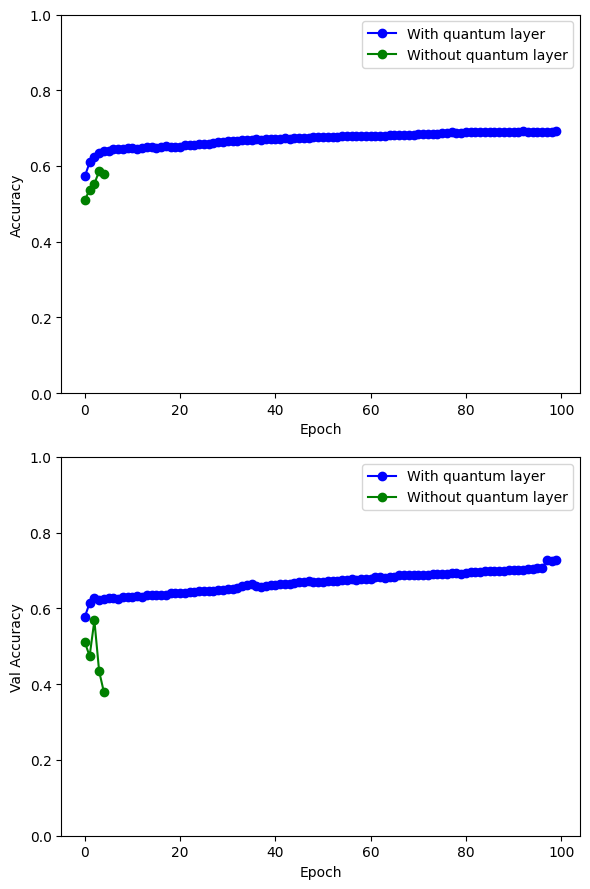

In [ ]:
import matplotlib.pyplot as plt

#plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-og", label="Without quantum layer")
ax2.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax2.set_ylabel("Val Accuracy")
ax2.set_ylim([0, 1])
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()
